### Utilizing DBSCAN and XGDBoost Classifiers for Credit Card Fraud Detection



## Dataset
We will use a dataset from Kaggle that contains Credit Card Data with instances of fraudulent behaviour. The dataset only has numerical data as the dataset has been transformed using PCA. Additionally the data does not contain very specific column names to ensure privacy of those from whom the data was gathered. The dataset is shown below with the column "Class" labelling the data. 

In [142]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


def load_data(data_path):
  data = pd.read_csv(data_path)
  data.fillna(method="ffill", inplace=True)
  return data


In [158]:
cc_data = load_data('creditcard.csv')
print(cc_data.head())
print(cc_data.columns)

X_Cols = [x for x in cc_data.columns if x != 'Class']
print(X_Cols)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## DBSCAN
DBSCAN, short for Density-Based Spatial Clustering of Applications with Noise, is a widely used clustering algorithm in data mining and machine learning. Its primary objective is to identify clusters of arbitrary shapes within a dataset, while also being able to distinguish noise points and remain unaffected by the input's order. The algorithm operates based on the concept of density, where clusters are defined as dense regions of data points separated by sparser areas. To accomplish this, DBSCAN considers two essential parameters: epsilon (ε) and the minimum number of points (minPts).

Epsilon is a hyperparameter that specifies the radius to consider datapoints around a considered datapoint. MinPts is the minimum number of points that must be within radius epsilon of a considered datapoint for that point to be considered a core point.

The algorithm considers datapoints and counts the number of neighboring points within epsilon distance. If the count of points is larger than minPts, the point is considered a core and the points are added to the cluster. All of the points in the set are considered recursively. If a datapoint has less than minPts neighboring points, it is considered an outlier.

# Selecting Hyperparameters
To select the best value for epsilon and minPts we must analyze our dataset. To pick the best epsilon we can first plot a K-distance graph.

In [28]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=2).fit(cc_data[X_Cols])
distances, indices = neighbors.kneighbors(cc_data[X_Cols])

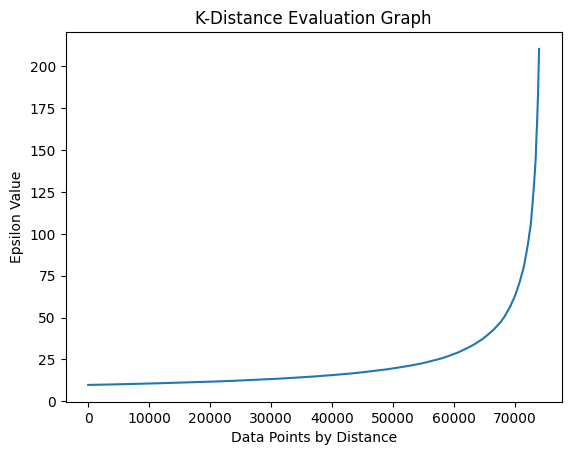

In [72]:
distances_plot = np.sort(distances, axis=0)[:,1]
# Only plot points at the graph's elbow
plt.plot(distances_plot[210000:284000])
plt.xlabel('Data Points by Distance')
plt.ylabel('Epsilon Value')
plt.title('K-Distance Evaluation Graph')
plt.show()

The best epsilon value is roughly where the graph steeply curves upwards. Based on the graph, we can pick an ideal epsilon value of 90. 

MinPts is generally set to at least 2 times the data's dimensionality. In testing it appears as though 60 is too small so we can increase it to reduce cluster count. In our dataset case, the data has 30 dimensions. We will set the minPts value to 100.

In [91]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN on our input data
model = DBSCAN(eps=90, min_samples=100).fit(cc_data[X_Cols])

Now that the model is fit, we can visualize the clustering and assess the model's performance.

In [95]:
print("Clusters:", len(np.unique(model.labels_))-1)
print("Anomalies Detected:", list(model.labels_).count(-1))
print("True Anomaly Count:",cc_data['Class'].value_counts()[1])
TP = cc_data.iloc[np.argwhere(model.labels_ == -1).reshape((-1,))]['Class'].value_counts()[1]
print("True Positives:", TP)
print("False Positive:", list(model.labels_).count(-1) - TP)

Clusters: 25
Anomalies Detected: 41253
True Anomaly Count: 492
True Positives: 167
False Positive: 41086


Currently the model is producing far too many false positives. 

We can try to scale and reduce the dimensionality of our dataset as this can improve DBSCAN's performance. As all of the columns are already scaled except for the time and amount column, we can apply scaling to only those two.

In [159]:
from sklearn.decomposition import PCA

# Standardize and Normalize Data
scaler = StandardScaler()
cc_data_s = cc_data.copy()
cc_data_s = cc_data_s[X_Cols]
cc_data_s['Time'] = scaler.fit_transform(cc_data_s['Time'].values.reshape(-1,1));
cc_data_s['Amount'] = scaler.fit_transform(cc_data_s['Amount'].values.reshape(-1,1));

# Reduce dimensionality
pca = PCA(n_components = 2)
cc_data_p = pd.DataFrame(pca.fit_transform(cc_data_sn))
cc_data_p.columns = ['V1', 'V2']

<ipython-input-159-fd1f1b04fbb5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_data_s['Time'] = scaler.fit_transform(cc_data_s['Time'].values.reshape(-1,1));
<ipython-input-159-fd1f1b04fbb5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_data_s['Amount'] = scaler.fit_transform(cc_data_s['Amount'].values.reshape(-1,1));


Now we can once again find the ideal hyperparameters and fit the DBSCAN model.

In [123]:
new_neighbors = NearestNeighbors(n_neighbors=2).fit(cc_data_p)
new_distances, new_indices = new_neighbors.kneighbors(cc_data_p)

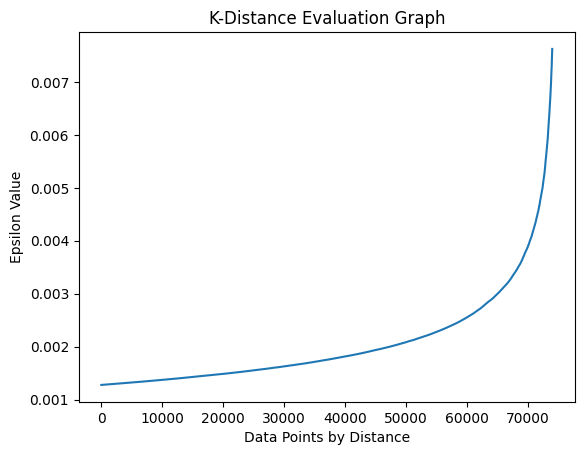

In [124]:
new_distances_plot = np.sort(new_distances, axis=0)[:,1]
# Only plot points at the graph's elbow
plt.plot(new_distances_plot[210000:284000])
plt.xlabel('Data Points by Distance')
plt.ylabel('Epsilon Value')
plt.title('K-Distance Evaluation Graph')
plt.show()

Here we can see that the new epsilon value we should use is roughly 0.003.

As the dataset only has 2 dimensions now we will set minPts to 4. 

In [125]:
# Fitting DBSCAN to reduced data
red_model = DBSCAN(eps=0.003, min_samples=4).fit(cc_data_p)

In [126]:
print("Clusters:", len(np.unique(red_model.labels_))-1)
print("Anomalies Detected:", list(red_model.labels_).count(-1))
print("True Anomaly Count:",cc_data['Class'].value_counts()[1])
TP = cc_data.iloc[np.argwhere(red_model.labels_ == -1).reshape((-1,))]['Class'].value_counts()[1]
print("True Positives:", TP)
print("False Positive:", list(red_model.labels_).count(-1) - TP)

Clusters: 3299
Anomalies Detected: 24090
True Anomaly Count: 492
True Positives: 2
False Positive: 24088


This reduced model seems to have significantly worse performance than the previous model. In this scenario we can see that the DBSCAN model does not seem to isolate the outliers effectively.

Now we will attempt to identify anomalous behaviour using a decision tree classifier. A XGDBoost classifier is a supervised learning method that may perform better.

## Extreme Gradient Boosting Classifier

XGDBoost is a machine learning algorithm known for its efficiency and effectiveness in handling structured data like ours. It is similar to other gradient boosting frameworks, which combines multiple weak predictive models to create a strong predictive model. This model has been used in real world applications due to its simplicity to implement and its performance.

To use this supervised learning model we must first preproccess our data once again in order to split off labels and create a training and testing dataset.



In [167]:
# Isolate data from labels
from sklearn.model_selection import train_test_split

def split_data(data):
  labels = data.values[:, -1]
  dat = data.values[:, 0:-1]
  # Default 25% test and 75% train split
  return train_test_split(dat, labels)

In [176]:
alt_model_data = cc_data.copy()
alt_model_data['Amount'] = scaler.fit_transform(alt_model_data['Amount'].values.reshape(-1,1));
alt_model_data['Time'] = scaler.fit_transform(alt_model_data['Time'].values.reshape(-1,1));

# alt_model_data.drop(['Time'], axis=1, inplace=True)

Xtr, Xts, ytr, yts = split_data(alt_model_data)

Now we can train the model on our train data. We are arbitrarily choosing the max depth based on computation time.

In [177]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5)
xgb.fit(Xtr, ytr)
preds = xgb.predict(Xts)

Now we will take a closer look at the performance of this model.

In [178]:
# Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(yts, preds)
print("Confusion Matrix\n",cm)
print("Accuracy:", accuracy_score(yts, preds))

Confusion Matrix
 [[71063     5]
 [   32   102]]
Accuracy: 0.9994803516755147


The gradient boosting technique worked significantly better on this dataset producing an accuracy of over 99%. Further the confusion matrix shows that the recall and precision of the model satisfactory.

In our dataset we had clusters of behaviors with varying densities. This, paired with the dimensionality of our data, proved very difficult for DBSCAN.